In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# STEP 3: Set paths
csv_path = '/content/drive/MyDrive/UI_UX_Classifier/train_labels.csv'  # 🔁 Update this
image_folder = '/content/drive/MyDrive/UI_UX_Classifier/screenshots'  # 🔁 Update this

In [ ]:
# STEP 4: Load and preprocess CSV
df = pd.read_csv(csv_path)
df = df[['Image_Path', 'Overall_UX']]
df['Image_Path'] = df['Image_Path'].apply(lambda x: os.path.join(image_folder, os.path.basename(x)))
df['label'] = df['Overall_UX'].map({'Bad UX': 0, 'Good UX': 1})

In [ ]:
# STEP 5: Train/val split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
# STEP 6: Load images
IMG_SIZE = (224, 224)

In [ ]:
def load_images(df):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img_path = row['Image_Path']  # Get the image path
            # Check if the image path is valid
            if not os.path.exists(img_path):
                print(f"Warning: Image not found at path: {img_path}")
                continue  # Skip this image
            img = load_img(img_path, target_size=IMG_SIZE)  # Load image using the corrected path
            img = img_to_array(img) / 255.0
            X.append(img)
            y.append(row['label'])
        except Exception as e:
            print(f"Error loading image {row['Image_Path']}: {e}")
            continue  # Skip this image
    return np.array(X), to_categorical(y, 2)

In [ ]:
# STEP 7: Handle class imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df['label']), # provide the unique classes
                                     y=df['label']) # provide the target variable
class_weights = dict(enumerate(class_weights))

In [ ]:
# STEP 8 Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# STEP 9 Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# STEP 10 Build full model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# STEP 11 Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Load and preprocess images for training and validation
X_train, y_train = load_images(train_df) # Load training images using load_images function
X_val, y_val = load_images(val_df) # Load validation images using load_images function

 17%|█▋        | 171/1003 [01:49<07:59,  1.73it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 251/251 [02:26<00:00,  1.71it/s]


In [ ]:
# STEP 12 Train model
history = model.fit(
    X_train, y_train,  # Use X_train and y_train directly
    validation_data=(X_val, y_val),  # Use X_val and y_val for validation
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5249 - loss: 0.7965 - val_accuracy: 0.6414 - val_loss: 0.6329
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6003 - loss: 0.6906 - val_accuracy: 0.7371 - val_loss: 0.5809
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6566 - loss: 0.6361 - val_accuracy: 0.7211 - val_loss: 0.5671
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6750 - loss: 0.6221 - val_accuracy: 0.7211 - val_loss: 0.5571
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6905 - loss: 0.5904 - val_accuracy: 0.7410 - val_loss: 0.5468
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6800 - loss: 0.5940 - val_accuracy: 0.7490 - val_loss: 0.5402
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7173 - loss: 0.5803 - val_accuracy: 0.7490 - val_loss: 0.5348
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7377 - loss: 0.5626 - val_accuracy: 0.7530 - val_loss:

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val) # Use X_val and y_val instead of val_ds
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5501 - loss: 0.7185
Validation Accuracy: 0.5657
Validation Loss: 0.7128


In [ ]:
model.save('/content/drive/MyDrive/ui_ux_model.keras')
print("✅ Model saved in Keras format to Google Drive.")

✅ Model saved in Keras format to Google Drive.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ui_ux_model.keras')

In [ ]:
# Model Performance
from sklearn.metrics import classification_report

# STEP A: Load test CSV
test_df = pd.read_csv('/content/drive/MyDrive/UI_UX_Classifier/test.csv')
test_df['label'] = test_df['Overall_UX'].map({'Bad UX': 0, 'Good UX': 1})

# STEP B: Load test images
IMG_SIZE = (224, 224)

def load_test_images(df):
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['Image_Path']
        if not os.path.exists(image_path):
            print(f"Warning: Image not found at path: {image_path}")
            continue
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0
            X.append(img)
            y.append(row['label'])
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue
    return np.array(X), np.array(y)

X_test, y_true = load_test_images(test_df)


if X_test.size == 0:
    print("Error: No test images were loaded. Please check your test CSV and image paths.")
else:

    # STEP C: Predict
    y_pred_probs = model.predict(X_test)
    y_pred_labels = (y_pred_probs[:, 1] > 0.5).astype(int) # ✅ Extract probabilities for class 1 and then apply threshold
    #y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Use argmax to get class labels

    # STEP D: Classification Report
    print(classification_report(y_true, y_pred_labels, target_names=['Bad UX', 'Good UX']))

100%|██████████| 121/121 [00:01<00:00, 110.16it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
              precision    recall  f1-score   support

      Bad UX       0.72      0.65      0.69        52
     Good UX       0.76      0.81      0.78        69

    accuracy                           0.74       121
   macro avg       0.74      0.73      0.74       121
weighted avg       0.74      0.74      0.74       121



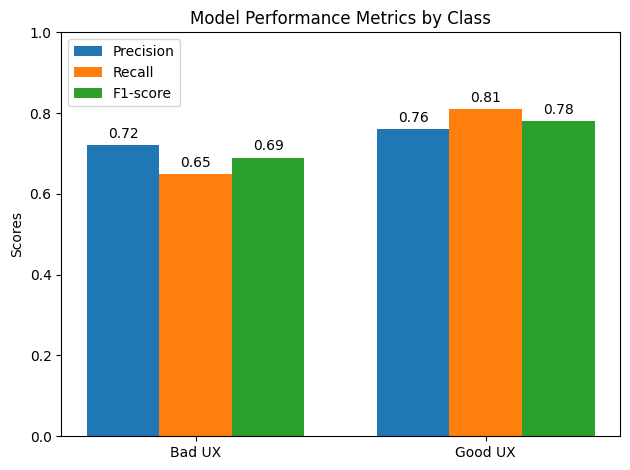

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your classification report
labels = ['Bad UX', 'Good UX']
precision = [0.72, 0.76]
recall = [0.65, 0.81]
f1_score = [0.69, 0.78]

x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

# Create the bar chart
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add labels and formatting
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


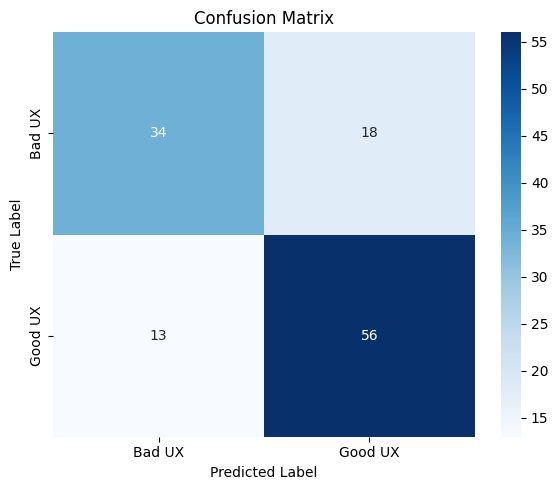

In [ ]:
# confusion matrix figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Use the existing y_true and X_test from your validation set
y_pred = model.predict(X_test)
# ✅ Changed from (y_pred > 0.5).astype("int32") to get predictions for the positive class
y_pred_classes = (y_pred[:, 1] > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot and save confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Bad UX", "Good UX"],
            yticklabels=["Bad UX", "Good UX"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()